In [1]:
# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_domain_score
from coolpuppy.lib.puputils import accumulate_values
from coolpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools.lib import io
from cooltools import insulation, expected_cis
from cooltools.lib import plotting

In [3]:
data_dir = '/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output'
Het_insul_df = pd.read_csv(f'{data_dir}/Het/Het.insulation.25000.window.125000.tsv', sep="\t")


In [4]:
display(Het_insul_df)

,chrom,start,end,region,is_bad_bin,log2_insulation_score_125000,n_valid_pixels_125000,boundary_strength_125000,is_boundary_125000
0,chr1,0,25000,chr1,True,NaN,0.0,NaN,False
1,chr1,25000,50000,chr1,True,NaN,0.0,NaN,False
2,chr1,50000,75000,chr1,True,NaN,0.0,NaN,False
3,chr1,75000,100000,chr1,True,NaN,0.0,NaN,False
4,chr1,100000,125000,chr1,True,NaN,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...
109263,JH584304.1,0,25000,JH584304.1,True,NaN,0.0,NaN,False
109264,JH584304.1,25000,50000,JH584304.1,True,NaN,0.0,NaN,False
109265,JH584304.1,50000,75000,JH584304.1,True,NaN,0.0,NaN,False
109266,JH584304.1,75000,100000,JH584304.1,True,NaN,0.0,NaN,False


In [5]:
# A  useful function to combine insulation score valleys into TADs and filter out very long "TADs"
def make_tads(insul_df, maxlen=1_500_000):
        tads = (
        insul_df.groupby("chrom")
        .apply(
            lambda x: pd.concat(
                [x[:-1].reset_index(drop=True), x[1:].reset_index(drop=True)],
                axis=1,
                ignore_index=True,
            )
        )
        .reset_index(drop=True)
        )
        tads.columns = [["chrom1", "start1", "end1", "chrom2", "start2", "end2"]]
        tads.columns = tads.columns.get_level_values(0)
        tads = tads[
            (tads["start2"] - tads["start1"]) <= maxlen
        ].reset_index(drop=True)
        tads["start"] = (tads["start1"] + tads["end1"]) // 2
        tads["end"] = (tads["start2"] + tads["end2"]) // 2
        tads = tads[["chrom1", "start", "end"]]
        tads.columns = ['chrom', 'start', 'end']
        return tads

In [6]:
Het_tads = make_tads(Het_insul_df[Het_insul_df['is_boundary_125000']][['chrom', 'start', 'end']])

/tmp/ipykernel_1132431/654156030.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [7]:
display(Het_tads)

,chrom,start,end
0,chr1,4737500,5112500
1,chr1,5112500,6312500
2,chr1,6312500,7337500
3,chr1,9487500,9712500
4,chr1,9712500,9962500
...,...,...,...
4060,chrX,166637500,167262500
4061,chrX,167262500,167912500
4062,chrX,167912500,168612500
4063,chrX,168612500,168937500


In [8]:
# Domain score（也叫 boundary strength / TAD strength），是用某个片段（snippet）里的 Hi-C contact enrichment 模式计算得来的一个分值。
# 这个做法最早由 Flyamer et al., 2017 提出，并被多个后续研究沿用。
def add_domain_score(snippet):
    snippet['domain_score'] = get_domain_score(snippet['data']) # Calculates domain score for each snippet according to Flyamer et al., 2017
    return snippet

In [9]:
def extra_sum_func(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domain_score')

In [11]:
Het_clr_25kb = cooler.Cooler(f'{data_dir}/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/25000')


In [12]:
view_df = pd.DataFrame({'chrom': Het_clr_25kb.chromnames,
                        'start': 0,
                        'end': Het_clr_25kb.chromsizes.values,
                        'name': Het_clr_25kb.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr1,0,195471971,chr1
1,chr2,0,182113224,chr2
2,chr3,0,160039680,chr3
3,chr4,0,156508116,chr4
4,chr5,0,151834684,chr5
...,...,...,...,...
61,JH584300.1,0,182347,JH584300.1
62,JH584301.1,0,259875,JH584301.1
63,JH584302.1,0,155838,JH584302.1
64,JH584303.1,0,158099,JH584303.1


In [13]:
Het_cvd_25kb = cooltools.expected_cis(
        clr=Het_clr_25kb,
        view_df=view_df,
    nproc=40
)
display(Het_cvd_25kb)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,0,NaN,7819,7545,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,25000,0.000227,7818,7443,NaN,NaN,NaN,NaN,0.000214,0.000227
2,chr1,chr1,2,50000,0.019832,7817,7428,511607.0,149.541317,65.447998,0.020132,0.018717,0.019832
3,chr1,chr1,3,75000,0.014011,7816,7426,342663.0,99.853127,43.841223,0.013446,0.013134,0.014011
4,chr1,chr1,4,100000,0.010709,7815,7423,261867.0,76.118183,33.508253,0.010254,0.010026,0.010709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109263,JH584304.1,JH584304.1,0,0,NaN,5,0,NaN,NaN,NaN,NaN,NaN,NaN
109264,JH584304.1,JH584304.1,1,25000,0.000227,4,0,NaN,NaN,NaN,NaN,NaN,0.000227
109265,JH584304.1,JH584304.1,2,50000,0.019832,3,0,0.0,0.000000,0.000000,NaN,NaN,0.019832
109266,JH584304.1,JH584304.1,3,75000,0.014011,2,0,0.0,0.000000,0.000000,NaN,NaN,0.014011


In [14]:
Het_cc = coolpup.CoordCreator(Het_tads, resolution=25000, features_format='bed', local=True, rescale_flank=1)


In [15]:
print(Het_cc)

In [16]:
Het_pu = coolpup.PileUpper(Het_clr_25kb, Het_cc, expected=Het_cvd_25kb, view_df=view_df, ignore_diags=2, rescale_size=99, rescale=True)


/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

In [17]:
display(Het_pu)

In [18]:
Het_pup = Het_pu.pileupsWithControl(postprocess_func=add_domain_score, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                            extra_sum_funcs={'domain_score': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,
                                                                              # it can be done using the extra_sum_funcs dictionary, which defines how to combine them.


INFO:coolpuppy:('chr1', 'chr1'): 295
INFO:coolpuppy:('chr2', 'chr2'): 325
INFO:coolpuppy:('chr3', 'chr3'): 219
INFO:coolpuppy:('chr4', 'chr4'): 257
INFO:coolpuppy:('chr5', 'chr5'): 251
INFO:coolpuppy:('chr6', 'chr6'): 224
INFO:coolpuppy:('chr7', 'chr7'): 221
INFO:coolpuppy:('chr8', 'chr8'): 187
INFO:coolpuppy:('chr9', 'chr9'): 226
INFO:coolpuppy:('chr10', 'chr10'): 221
INFO:coolpuppy:('chr11', 'chr11'): 247
INFO:coolpuppy:('chr12', 'chr12'): 169
INFO:coolpuppy:('chr13', 'chr13'): 185
INFO:coolpuppy:('chr14', 'chr14'): 151
INFO:coolpuppy:('chr15', 'chr15'): 166
INFO:coolpuppy:('chr16', 'chr16'): 141
INFO:coolpuppy:('chr17', 'chr17'): 143
INFO:coolpuppy:('chr18', 'chr18'): 145
INFO:coolpuppy:('chr19', 'chr19'): 108
INFO:coolpuppy:('chrX', 'chrX'): 177
INFO:coolpuppy:Total number of piled up windows: 295


In [19]:
display(Het_pup)

,group,data,n,num,domain_score,clr,resolution,flank,rescale_flank,chroms,...,control,pad_bins,coverage_norm,rescale,rescale_size,flip_negative_strand,ignore_diags,store_stripes,nproc,ignore_group_order
0,all,"[[nan, nan, 1.145677916625986, 1.0028813038124...",295,"[[0, 0, 6, 98, 141, 167, 214, 228, 249, 271, 2...","[2.0616699626740775, 1.1039575622835018, 1.187...",/lustre/home/acct-medlqian/medlqian-loop3/data...,25000,100000,1,"['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6...",...,False,4,False,True,99,False,2,False,1,False


In [20]:
Het_pup.loc[0, 'domain_score'][:10]

[np.float64(2.0616699626740775),
 np.float64(1.1039575622835018),
 np.float64(1.1873628160985519),
 np.float64(0.8519685226134992),
 np.float64(0.8053078653630715),
 np.float64(1.0562872665207472),
 np.float64(0.8984767496539018),
 np.float64(1.0821034316502036),
 np.float64(0.9037270837777841),
 np.float64(1.2234699902547939)]

In [21]:
len(Het_pup.loc[0, 'domain_score'])


4058

In [22]:
np.mean(Het_pup.loc[0, 'domain_score'])


np.float64(1.119163520563796)

In [23]:
Het_pup.loc[0, 'data'].shape

(99, 99)

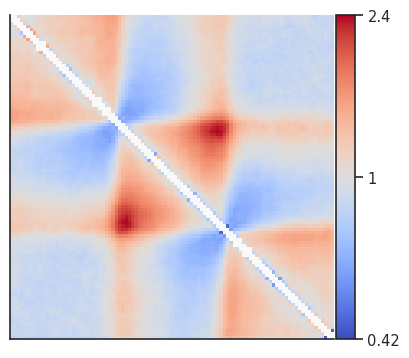

In [43]:
plotpup.plot(Het_pup,
             score=False,
             height=5,
            vmax=2.4)
plt.savefig('../plots_v1/Het_tad_domain_score_pup_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

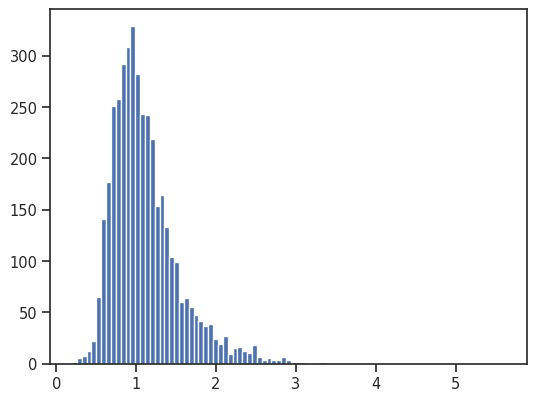

In [25]:
plt.hist(Het_pup.loc[0, 'domain_score'], bins='auto');

In [27]:
Homo_insul_df = pd.read_csv(f'{data_dir}/Homo/Homo.insulation.25000.window.125000.tsv', sep="\t")

Homo_tads = make_tads(Homo_insul_df[Homo_insul_df['is_boundary_125000']][['chrom', 'start', 'end']])

Homo_clr_25kb = cooler.Cooler(f'{data_dir}/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/25000')

Homo_cvd_25kb = cooltools.expected_cis(
        clr=Homo_clr_25kb,
        view_df=view_df,
    nproc=40
)
display(Homo_cvd_25kb)

Homo_cc = coolpup.CoordCreator(Homo_tads, resolution=25000, features_format='bed', local=True, rescale_flank=1)

Homo_pu = coolpup.PileUpper(Homo_clr_25kb, Homo_cc, expected=Homo_cvd_25kb, view_df=view_df, ignore_diags=2, rescale_size=99, rescale=True)

Homo_pup = Homo_pu.pileupsWithControl(postprocess_func=add_domain_score, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                            extra_sum_funcs={'domain_score': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,
                                                                              # it can be done using the extra_sum_funcs dictionary, which defines how to combine them.



/tmp/ipykernel_1132431/654156030.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,0,NaN,7819,7552,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,25000,0.000235,7818,7457,NaN,NaN,NaN,NaN,0.000223,0.000235
2,chr1,chr1,2,50000,0.020574,7817,7442,515707.0,155.906458,65.972496,0.020950,0.019493,0.020574
3,chr1,chr1,3,75000,0.014638,7816,7438,347567.0,104.674071,44.468654,0.014073,0.013772,0.014638
4,chr1,chr1,4,100000,0.011276,7815,7438,268372.0,80.709721,34.340627,0.010851,0.010614,0.011276
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109263,JH584304.1,JH584304.1,0,0,NaN,5,0,NaN,NaN,NaN,NaN,NaN,NaN
109264,JH584304.1,JH584304.1,1,25000,0.000235,4,0,NaN,NaN,NaN,NaN,NaN,0.000235
109265,JH584304.1,JH584304.1,2,50000,0.020574,3,0,0.0,0.000000,0.000000,NaN,NaN,0.020574
109266,JH584304.1,JH584304.1,3,75000,0.014638,2,0,0.0,0.000000,0.000000,NaN,NaN,0.014638


/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/coolpup/lib/python3.11/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

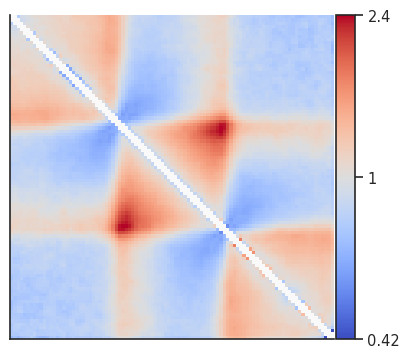

In [42]:
plotpup.plot(Homo_pup,
             score=False,
             height=5,
            vmax=2.4)
plt.savefig('../plots_v1/Homo_tad_domain_score_pup_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

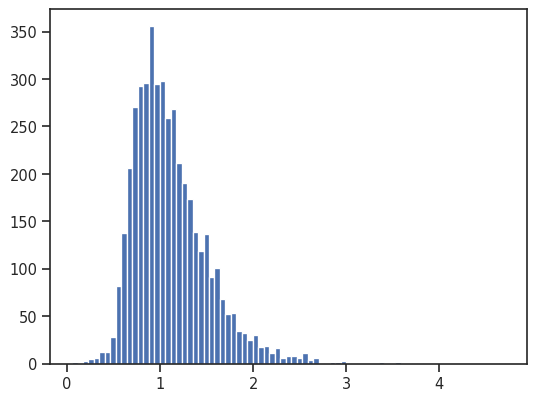

In [29]:
plt.hist(Homo_pup.loc[0, 'domain_score'], bins='auto');

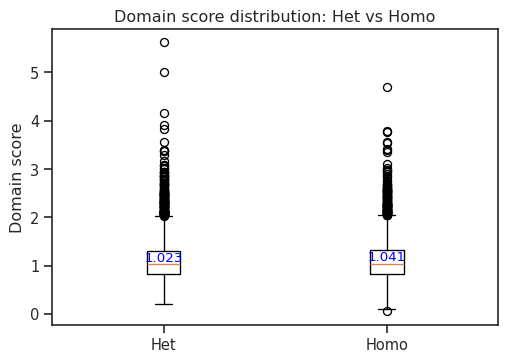

In [33]:
import matplotlib.pyplot as plt

het_scores = Het_pup.loc[0, 'domain_score']
homo_scores = Homo_pup.loc[0, 'domain_score']

data = [het_scores, homo_scores]  # 顺序：Het, Homo

plt.figure(figsize=(6, 4))
box = plt.boxplot(data, labels=['Het', 'Homo'])

plt.ylabel('Domain score')
plt.title('Domain score distribution: Het vs Homo')

medians = [line.get_ydata()[0] for line in box['medians']]

for i, median in enumerate(medians):
    plt.text(i + 1, median, f'{median:.3f}',
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=10,
             color='blue')

plt.savefig('../plots_v1/domain_score_boxplot_with_median.pdf', dpi=300, bbox_inches='tight')
plt.show()
